In [107]:
import pandas as pd
import numpy as np

codeA = pd.read_csv('data/Train/tc_codea_코드A.csv')
codeB = pd.read_csv('data/Train/tc_codeb_코드B.csv')
code_area = pd.read_csv('data/Train/tc_sgg_시군구코드.csv')

# 라벨링 데이터

# 그 뭘 했었는지 - 방문장소 , 여기서 방문한 장소의 타입을 찾을 수 있음
visit_area_info = pd.read_csv('data/Train/tn_visit_area_info_방문지정보_merged.csv')

traveler_master = pd.read_csv('data/Train/tn_traveller_master_여행객 Master_merged.csv')

# 돈은 얼마나 쓰는지 - 지출내역
adv_consume_his_act = pd.read_csv('data/Train/tn_activity_consume_his_활동소비내역_t.csv')

# 뭘 타고는지 - 이동수단소비내역
move_consume_his = pd.read_csv('data/Train/tn_mvmn_consume_his_이동수단소비내역_merged.csv')

companion_info = pd.read_csv('data/Train/tn_companioninfo동반자정보_t.csv')

# 여행 목적 - 여행 페르소나
travel = pd.read_csv('./data/Train/tn_travel_여행_merged.csv')

In [108]:
# 방문지에 대한 결측치 처리
valid_area_type_codes = list(range(1, 9))
visit_area_info = visit_area_info[ (visit_area_info['VISIT_AREA_TYPE_CD'].isin(valid_area_type_codes))]
visit_area_info = visit_area_info[~visit_area_info['VISIT_AREA_NM'].str.contains('집')]

## 1. 각 테이블에서 필요한 특성 집계

### 방문지 관련 집계

In [109]:
visit_counts = visit_area_info.groupby('TRAVEL_ID').agg({
    'VISIT_AREA_NM': 'count',  # 방문 장소 수
    'DGSTFN': 'mean',  # 평균 만족도
    'REVISIT_INTENTION': 'mean',  # 평균 재방문 의향
    'RESIDENCE_TIME_MIN': 'sum'  # 총 체류 시간
}).reset_index()
visit_counts.columns = ['TRAVEL_ID', 'visit_count', 'avg_satisfaction', 'avg_revisit_intention', 'total_residence_time']


### 활동 유형 집계

In [110]:
activity_summary = adv_consume_his_act.groupby('TRAVEL_ID').agg({
    'ACTIVITY_TYPE_CD': ['nunique', lambda x: ','.join(x.astype(str).unique())]  # 활동 유형 수와 목록
}).reset_index()
activity_summary.columns = ['TRAVEL_ID', 'activity_type_count', 'activity_types']

### 이동 수단 집계

In [111]:
move_summary = move_consume_his.groupby('TRAVEL_ID').agg({
    'MVMN_SE_NM': ['nunique', lambda x: ','.join(x.unique())]  # 이동 수단 수와 목록
}).reset_index()
move_summary.columns = ['TRAVEL_ID', 'transport_count', 'transport_types']

### 동반자 정보 집계

In [112]:
companion_summary = companion_info.groupby('TRAVEL_ID').agg({
    'REL_CD': ['nunique', lambda x: ','.join(x.astype(str).unique())]  # 동반자 유형 수와 목록
}).reset_index()
companion_summary.columns = ['TRAVEL_ID', 'companion_type_count', 'companion_types']

## 2. 기본 여행-여행자 데이터 병합

In [113]:
base_df = pd.merge(travel, traveler_master, on='TRAVELER_ID', how='inner')

## 3. 집계된 특성들을 기본 데이터에 병합


In [114]:
master_df = base_df.copy()
master_df = pd.merge(master_df, visit_counts, on='TRAVEL_ID', how='left')
master_df = pd.merge(master_df, activity_summary, on='TRAVEL_ID', how='left')
master_df = pd.merge(master_df, move_summary, on='TRAVEL_ID', how='left')
master_df = pd.merge(master_df, companion_summary, on='TRAVEL_ID', how='left')

## 4. 결측치 처리 및 최종 데이터 정리

In [115]:
master_df = master_df.fillna({
    'visit_count': 0,
    'activity_type_count': 0,
    'transport_count': 0,
    'companion_type_count': 0,
})

### 필요한 특성에 대한 결측치는 제거

In [116]:
master_df = master_df.dropna(subset=['TRAVEL_STYL_1', 'TRAVEL_MOTIVE_1'])
master_df.reset_index(drop=True, inplace=True)
master_df['MVMN_NM'] = master_df['MVMN_NM'].fillna("걷기")
master_df['transport_types'] = master_df['transport_types'].fillna("걷기")
master_df['TRAVEL_MOTIVE_2'] = master_df['TRAVEL_MOTIVE_2'].fillna(10)
master_df['TRAVEL_MOTIVE_3'] = master_df['TRAVEL_MOTIVE_3'].fillna(10)
master_df['activity_types'] = master_df['activity_types'].fillna(12)
master_df['EDU_FNSH_SE'] = master_df['EDU_FNSH_SE'].fillna(13)
master_df = master_df.drop('JOB_ETC', axis=1)
master_df = master_df.drop('HOUSE_INCOME', axis=1)




## 5. 최종 데이터셋 저장

In [117]:
null_counts = master_df.isnull().sum()
print(null_counts[null_counts > 0])
master_df.to_csv('svd_results.csv', index=False)
master_df.shape
master_df.isnull().sum().sum()

avg_satisfaction          368
avg_revisit_intention     368
total_residence_time      368
companion_types          1936
dtype: int64


3040

# Neural Collaborative Filtering for Travel Recommendation


In [118]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Flatten, Concatenate, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import matplotlib.pyplot as plt

## 1. 데이터 로드

In [119]:
master_df = pd.read_csv('svd_results.csv')
print(f"데이터 크기: {master_df.shape}")
master_df.head()

데이터 크기: (10240, 53)


,TRAVEL_ID,TRAVEL_NM,TRAVELER_ID,TRAVEL_PURPOSE,TRAVEL_START_YMD,TRAVEL_END_YMD,MVMN_NM,TRAVEL_PERSONA,TRAVEL_MISSION,TRAVEL_MISSION_CHECK,...,visit_count,avg_satisfaction,avg_revisit_intention,total_residence_time,activity_type_count,activity_types,transport_count,transport_types,companion_type_count,companion_types
0,e_e000004,E03,e000004,3,2023-04-30,2023-05-01,걷기,서울 외 수도권 방문/수도권 거주/40세 이상/자녀동반/일반미션,3,3;4;11,...,3.0,4.000000,3.333333,150.0,0.0,12,0.0,걷기,2.0,"2,1"
1,e_e000006,E03,e000006,21,2023-04-30,2023-05-02,걷기,경기 방문/거주지 구분 없음/39세 이하/특별미션,21,21;10;27,...,1.0,5.000000,5.000000,150.0,2.0,"1,2",2.0,"자가용(승용/승합/트럭 등등),지하철",1.0,5
2,e_e000009,E03,e000009,2;4,2023-04-29,2023-05-01,걷기,서울 외 수도권 방문/수도권 거주/39세 이하/커플/일반미션,2;4,22;1;7,...,3.0,4.666667,4.666667,210.0,3.0,"1,2,6",1.0,자가용(승용/승합/트럭 등등),1.0,8
3,e_e000010,E01,e000010,3;6,2023-04-29,2023-05-01,걷기,서울 방문/수도권 외 거주/39세 이하/나홀로 여행/일반미션,3;6,6;3;1,...,4.0,4.500000,4.250000,810.0,2.0,"1,3",2.0,"택시,버스 + 지하철",0.0,NaN
4,e_e000011,E01,e000011,1;21,2023-04-28,2023-05-01,걷기,서울 방문/수도권 외 거주/40세 이상/커플/일반미션,1;21,6;2;24,...,2.0,4.500000,4.500000,120.0,2.0,"1,2",3.0,"자가용(승용/승합/트럭 등등),지하철,KTX/SRT(고속열차)",1.0,7


## 2. 특성 엔지니어링 및 전처리

In [120]:
# 범주형 특성과 수치형 특성 분리
categorical_features = [
    'TRAVEL_ID', 'TRAVELER_ID', 'TRAVEL_PURPOSE', 'MVMN_NM', 'TRAVEL_PERSONA',
    'RESIDENCE_SGG_CD', 'GENDER', 'AGE_GRP', 'EDU_NM', 'EDU_FNSH_SE', 'MARR_STTS',
    'JOB_NM', 'TRAVEL_TERM', 'TRAVEL_STYL_1', 'TRAVEL_STYL_2', 'TRAVEL_STYL_3',
    'TRAVEL_MOTIVE_1', 'TRAVEL_MOTIVE_2', 'TRAVEL_MOTIVE_3', 'transport_types'
]

numerical_features = [
    'TRAVEL_COMPANIONS_NUM', 'visit_count', 'avg_satisfaction', 'avg_revisit_intention',
    'total_residence_time', 'activity_type_count', 'transport_count', 'companion_type_count'
]

# 타겟 변수 설정 (예시: 만족도)
target_variable = 'avg_satisfaction'

### 2.1 범주형 특성 인코딩

In [121]:
# LabelEncoder를 사용하여 범주형 특성 인코딩
encoders = {}
for feature in categorical_features:
    if feature in master_df.columns:
        # null 값을 'unknown'으로 대체
        master_df[feature] = master_df[feature].fillna('unknown')
        
        # LabelEncoder 적용
        le = LabelEncoder()
        master_df[f'{feature}_encoded'] = le.fit_transform(master_df[feature].astype(str))
        encoders[feature] = le

# 인코딩된 특성들의 목록을 생성
encoded_categorical_features = [f'{feature}_encoded' for feature in categorical_features 
                               if feature in master_df.columns]


### 2.2 사용자와 아이템 인덱스 생성

In [122]:
# 사용자(여행자)와 아이템(여행) 인덱스 생성
user_encoder = LabelEncoder()
master_df['user_idx'] = user_encoder.fit_transform(master_df['TRAVELER_ID'])

item_encoder = LabelEncoder()
master_df['item_idx'] = item_encoder.fit_transform(master_df['TRAVEL_ID'])

# 사용자와 아이템 수
num_users = len(user_encoder.classes_)
num_items = len(item_encoder.classes_)

print(f"고유 사용자 수: {num_users}")
print(f"고유 여행 수: {num_items}")

고유 사용자 수: 10240
고유 여행 수: 10240


### 2.3 수치형 특성 정규화

In [123]:
# 결측치 처리
for feature in numerical_features:
    if feature in master_df.columns:
        master_df[feature] = master_df[feature].fillna(master_df[feature].median())

# 수치형 특성 정규화
scaler = StandardScaler()
scaled_numerical_features = []

for feature in numerical_features:
    if feature in master_df.columns:
        # 타겟 변수는 정규화에서 제외
        if feature != target_variable:
            feature_name = f'{feature}_scaled'
            master_df[feature_name] = scaler.fit_transform(master_df[[feature]])
            scaled_numerical_features.append(feature_name)

## 3. 데이터 분할

In [124]:
# 사용할 특성 정의
features = ['user_idx', 'item_idx'] + encoded_categorical_features + scaled_numerical_features

# 타겟 변수가 없는 레코드는 제외
master_df = master_df.dropna(subset=[target_variable])

# 학습 데이터와 테스트 데이터 분할
X = master_df[features]
y = master_df[target_variable]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"학습 데이터 크기: {X_train.shape}")
print(f"테스트 데이터 크기: {X_test.shape}")

학습 데이터 크기: (8192, 29)
테스트 데이터 크기: (2048, 29)


## 4. 뉴럴 콜라보레이티브 필터링 모델 구현

In [125]:
def build_ncf_model(num_users, num_items, cat_feature_vocab_sizes, embedding_size=50, num_numerical=len(scaled_numerical_features)):
    """
    Neural Collaborative Filtering 모델 구현
    """
    # 사용자 임베딩 계층
    user_input = Input(shape=(1,), name='user_input')
    user_embedding = Embedding(num_users, embedding_size, name='user_embedding')(user_input)
    user_flatten = Flatten(name='user_flatten')(user_embedding)
    
    # 아이템 임베딩 계층
    item_input = Input(shape=(1,), name='item_input')
    item_embedding = Embedding(num_items, embedding_size, name='item_embedding')(item_input)
    item_flatten = Flatten(name='item_flatten')(item_embedding)
    
    # 범주형 특성 임베딩 계층
    categorical_inputs = []
    categorical_embeddings = []
    
    for i, (feature, vocab_size) in enumerate(cat_feature_vocab_sizes.items()):
        cat_input = Input(shape=(1,), name=f'cat_input_{i}')
        categorical_inputs.append(cat_input)
        
        # 임베딩 크기는 어휘 크기의 제곱근으로 설정 (경험적 규칙)
        embed_size = min(50, int(np.sqrt(vocab_size)))
        
        cat_embedding = Embedding(vocab_size, embed_size, name=f'cat_embedding_{i}')(cat_input)
        cat_flatten = Flatten(name=f'cat_flatten_{i}')(cat_embedding)
        categorical_embeddings.append(cat_flatten)
    
    # 수치형 특성 입력 계층
    numerical_input = Input(shape=(num_numerical,), name='numerical_input')
    
    # 모든 특성 결합
    combined = Concatenate()([user_flatten, item_flatten] + categorical_embeddings + [numerical_input])
    
    # 은닉 계층
    hidden1 = Dense(256, activation='relu')(combined)
    dropout1 = Dropout(0.2)(hidden1)
    hidden2 = Dense(128, activation='relu')(dropout1)
    dropout2 = Dropout(0.2)(hidden2)
    hidden3 = Dense(64, activation='relu')(dropout2)
    dropout3 = Dropout(0.2)(hidden3)
    
    # 출력 계층 (만족도 예측)
    output = Dense(1, activation='linear')(dropout3)
    
    # 모델 생성
    model = Model(
        inputs=[user_input, item_input] + categorical_inputs + [numerical_input],
        outputs=output
    )
    
    # 모델 컴파일
    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )
    
    return model

## 5. 모델 학습 및 평가

In [126]:
# 범주형 특성 어휘 크기 계산
cat_feature_vocab_sizes = {}
for i, feature in enumerate(encoded_categorical_features):
    cat_feature_vocab_sizes[feature] = int(master_df[feature].max() + 1)

# 모델 생성
model = build_ncf_model(
    num_users=num_users,
    num_items=num_items,
    cat_feature_vocab_sizes=cat_feature_vocab_sizes,
    num_numerical=len(scaled_numerical_features)
)

# 모델 구조 출력
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 user_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 item_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 cat_input_0 (InputLayer)    [(None, 1)]                  0         []                            
                                                                                                  
 cat_input_1 (InputLayer)    [(None, 1)]                  0         []                            
                                                                                            

### 5.1 모델 학습 데이터 준비

In [127]:
def prepare_model_inputs(X_data, encoded_categorical_features, scaled_numerical_features):
    """모델 입력 데이터 준비 함수"""
    inputs = [
        X_data['user_idx'].values.reshape(-1, 1),
        X_data['item_idx'].values.reshape(-1, 1)
    ]
    
    # 범주형 특성 추가
    for feature in encoded_categorical_features:
        inputs.append(X_data[feature].values.reshape(-1, 1))
    
    # 수치형 특성 추가
    inputs.append(X_data[scaled_numerical_features].values)
    
    return inputs

# 학습 및 테스트 데이터 준비
train_inputs = prepare_model_inputs(X_train, encoded_categorical_features, scaled_numerical_features)
test_inputs = prepare_model_inputs(X_test, encoded_categorical_features, scaled_numerical_features)

### 5.2 모델 학습

In [128]:
# 모델 학습
epochs = 20
batch_size = 64

history = model.fit(
    train_inputs, y_train,
    validation_data=(test_inputs, y_test),
    epochs=epochs,
    batch_size=batch_size,
    verbose=1
)

Epoch 1/20
128/128 [==============================] - 2s 6ms/step - loss: 2.5549 - mae: 1.1413 - val_loss: 0.3353 - val_mae: 0.4018
Epoch 2/20
128/128 [==============================] - 1s 4ms/step - loss: 0.5472 - mae: 0.5739 - val_loss: 0.2589 - val_mae: 0.3408
Epoch 3/20
128/128 [==============================] - 1s 4ms/step - loss: 0.4236 - mae: 0.5065 - val_loss: 0.2424 - val_mae: 0.3340
Epoch 4/20
128/128 [==============================] - 1s 4ms/step - loss: 0.3581 - mae: 0.4683 - val_loss: 0.2223 - val_mae: 0.3003
Epoch 5/20
128/128 [==============================] - 1s 5ms/step - loss: 0.3171 - mae: 0.4391 - val_loss: 0.2358 - val_mae: 0.3364
Epoch 6/20
128/128 [==============================] - 1s 5ms/step - loss: 0.3016 - mae: 0.4299 - val_loss: 0.2238 - val_mae: 0.3055
Epoch 7/20
128/128 [==============================] - 1s 5ms/step - loss: 0.2844 - mae: 0.4218 - val_loss: 0.2285 - val_mae: 0.3243
Epoch 8/20
128/128 [==============================] - 1s 4ms/step - loss: 0.

### 5.3 학습 결과 시각화

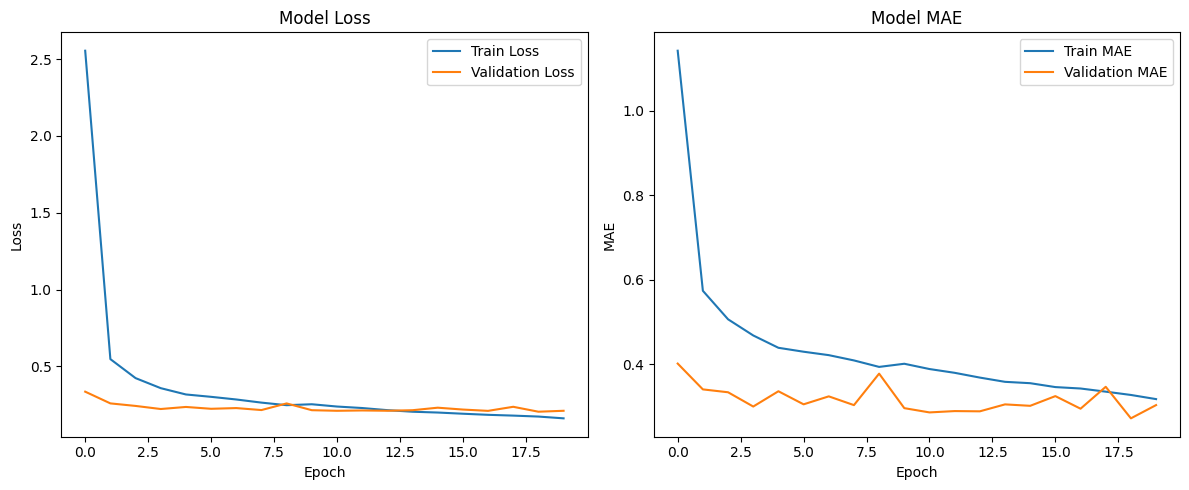

In [129]:
# 학습 결과 시각화
plt.figure(figsize=(12, 5))

# Loss 그래프
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# MAE 그래프
plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

### 5.4 모델 평가

In [130]:
# 테스트 데이터로 모델 평가
test_loss, test_mae = model.evaluate(test_inputs, y_test, verbose=0)
print(f"테스트 Loss: {test_loss:.4f}")
print(f"테스트 MAE: {test_mae:.4f}")

# 모델 저장
model.save('ncf_travel_model.h5')

테스트 Loss: 0.2108
테스트 MAE: 0.3037


/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 6. 여행 추천 시스템 구현

In [131]:
def recommend_travel_for_user(user_id, top_n=5):
    try:
        # 사용자 ID를 인덱스로 변환
        user_idx = user_encoder.transform([user_id])[0]
        print(f"사용자 ID {user_id}를 인덱스 {user_idx}로 변환했습니다.")
    except Exception as e:
        print(f"사용자 ID 변환 오류: {e}")
        return []
    
    # 모든 여행에 대한 점수 계산
    all_items = list(set(master_df['TRAVEL_ID']))
    predictions = []
    
    for item_id in all_items[:20]:  # 테스트를 위해 20개만 처리
        try:
            # 여행 ID를 인덱스로 변환
            item_idx = item_encoder.transform([item_id])[0]
            
            # 이 여행에 대한 데이터 준비
            item_data = master_df[master_df['TRAVEL_ID'] == item_id].iloc[0]
            
            print(f"여행 ID {item_id} 처리 중...")
            
            # 모델 입력 준비
            inputs = [
                np.array([[user_idx]]),
                np.array([[item_idx]])
            ]
            
            # 범주형 특성 추가
            for feature in encoded_categorical_features:
                try:
                    feature_value = item_data[feature]
                    inputs.append(np.array([[feature_value]], dtype=np.int32))
                except KeyError as e:
                    print(f"  KeyError: {feature} 특성을 찾을 수 없습니다.")
                    raise
            
            # 수치형 특성 추가 - 형식 변환 적용
            try:
                numerical_data = np.array([item_data[scaled_numerical_features].values], dtype=np.float32)
                inputs.append(numerical_data)
                print(f"  수치형 특성 형태: {numerical_data.shape}, 타입: {numerical_data.dtype}")
            except KeyError as e:
                print(f"  KeyError: 수치형 특성에서 오류 발생 - {e}")
                raise
            
            # 예측 시도
            try:
                pred = model.predict(inputs, verbose=0)[0][0]
                print(f"  예측 성공: 점수 = {pred:.2f}")
                predictions.append((item_id, pred))
            except Exception as e:
                print(f"  예측 오류: {e}")
                raise
                
        except Exception as e:
            print(f"여행 ID {item_id} 처리 중 오류 발생: {str(e)}")
            continue
    
    # 예측 점수에 따라 정렬
    predictions.sort(key=lambda x: x[1], reverse=True)
    
    # 결과 확인
    if not predictions:
        print("추천 결과가 없습니다.")
        
        # 콘텐츠 기반 추천 대안 로직은 그대로 유지
        # ...
    
    return predictions[:top_n]

### 6.1 추천 테스트

In [132]:
# 샘플 사용자에게 여행 추천
sample_user = master_df['TRAVELER_ID'].iloc[0]
recommendations = recommend_travel_for_user(sample_user, top_n=5)

print(f"사용자 '{sample_user}'에 대한 추천 여행:")
for i, (travel_id, score) in enumerate(recommendations, 1):
    travel = master_df[master_df['TRAVEL_ID'] == travel_id].iloc[0]
    print(f"{i}. 여행 ID: {travel_id}, 예상 만족도: {score:.2f}")
    print(f"   여행명: {travel.get('TRAVEL_NM', '정보 없음')}")
    print(f"   여행 스타일: {travel.get('TRAVEL_STYL_1', '정보 없음')}")
    print(f"   여행 동기: {travel.get('TRAVEL_MOTIVE_1', '정보 없음')}")
    print()

사용자 ID e000004를 인덱스 1로 변환했습니다.
여행 ID e_e006506 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.60
여행 ID f_f008543 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.52
여행 ID e_e003591 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.06
여행 ID e_e005166 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.93
여행 ID e_e008243 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.40
여행 ID g_g000688 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.91
여행 ID g_g002277 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.51
여행 ID h_h003744 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.25
여행 ID h_h005435 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.18
여행 ID f_f011748 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 4.54
여행 ID f_f000704 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.97
여행 ID g_g006775 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32
  예측 성공: 점수 = 3.86
여행 ID g_g011972 처리 중...
  수치형 특성 형태: (1, 7), 타입: float32


## 장소 추천

In [133]:
def recommend_places_for_user(user_id, top_n=3):
    """
    특정 사용자에게 방문할 만한 장소 추천
    
    Parameters:
    ----------
    user_id : str
        추천을 받을 사용자 ID
    top_n : int
        추천할 장소 개수
        
    Returns:
    -------
    list of tuples
        (장소ID, 장소명, 추천 점수) 형태의 튜플 리스트
    """
    # 사용자의 여행 스타일과 동기 파악
    try:
        user_data = master_df[master_df['TRAVELER_ID'] == user_id]
        if len(user_data) == 0:
            print(f"사용자 ID {user_id}에 대한 정보를 찾을 수 없습니다.")
            return []
            
        user_travel_style = user_data['TRAVEL_STYL_1'].iloc[0]
        user_travel_motive = user_data['TRAVEL_MOTIVE_1'].iloc[0]
        user_age_grp = user_data['AGE_GRP'].iloc[0]
        
        print(f"사용자 프로필: 여행 스타일={user_travel_style}, 여행 동기={user_travel_motive}, 연령대={user_age_grp}")
        
    except Exception as e:
        print(f"사용자 정보 조회 오류: {e}")
        return []
    
    # 사용자가 이전에 방문한 장소들 확인
    user_travels = master_df[master_df['TRAVELER_ID'] == user_id]['TRAVEL_ID'].tolist()
    
    # 사용자의 여행과 연결된 방문 장소들 확인
    visited_places = set()
    if len(user_travels) > 0:
        for travel_id in user_travels:
            places = visit_area_info[visit_area_info['TRAVEL_ID'] == travel_id]['VISIT_AREA_ID'].tolist()
            visited_places.update(places)
    
    print(f"사용자가 이미 방문한 장소 수: {len(visited_places)}")
    
    # 장소 추천 로직
    # 1. 비슷한 여행 스타일과 동기를 가진 다른 사용자들의 여행 찾기
    similar_travels = master_df[
        (master_df['TRAVEL_STYL_1'] == user_travel_style) | 
        (master_df['TRAVEL_MOTIVE_1'] == user_travel_motive)
    ]['TRAVEL_ID'].unique()
    
    # 2. 해당 여행들에 포함된 장소 중 만족도가 높은 곳 찾기
    place_scores = {}
    
    for travel_id in similar_travels:
        places = visit_area_info[visit_area_info['TRAVEL_ID'] == travel_id]
        
        for _, place in places.iterrows():
            place_id = place['VISIT_AREA_ID']
            
            # 이미 방문한 장소는 제외
            if place_id in visited_places:
                continue
                
            # 장소 점수 계산 (만족도와 재방문 의향을 기반으로)
            satisfaction = place.get('DGSTFN', 0) 
            revisit = place.get('REVISIT_INTENTION', 0)
            
            # NaN 값 처리
            if pd.isna(satisfaction):
                satisfaction = 0
            if pd.isna(revisit):
                revisit = 0
            
            # 가중치를 적용한 종합 점수
            score = 0.7 * satisfaction + 0.3 * revisit
            
            if place_id in place_scores:
                # 이미 점수가 있는 경우 평균값 계산
                place_scores[place_id]['count'] += 1
                place_scores[place_id]['total_score'] += score
                place_scores[place_id]['avg_score'] = place_scores[place_id]['total_score'] / place_scores[place_id]['count']
            else:
                # 새로운 장소 추가
                place_scores[place_id] = {
                    'place_id': place_id,
                    'place_name': place['VISIT_AREA_NM'],
                    'count': 1,
                    'total_score': score,
                    'avg_score': score
                }
    
    # 점수 기준으로 정렬하여 상위 N개 추천
    sorted_places = sorted(
        [info for info in place_scores.values()],
        key=lambda x: (x['avg_score'], x['count']), 
        reverse=True
    )
    
    # 상위 N개 장소 반환
    top_places = []
    for place in sorted_places[:top_n]:
        top_places.append((
            place['place_id'],
            place['place_name'],
            place['avg_score']
        ))
    
    return top_places

# 사용 예시
def display_place_recommendations(user_id, top_n=3):
    """
    사용자에게 추천된 장소를 보기 좋게 출력
    """
    recommended_places = recommend_places_for_user(user_id, top_n)
    
    if not recommended_places:
        print(f"사용자 '{user_id}'에게 추천할 장소를 찾을 수 없습니다.")
        return
    
    print(f"\n사용자 '{user_id}'에게 추천하는 장소:")
    print("="*50)
    
    for i, (place_id, place_name, score) in enumerate(recommended_places, 1):
        print(f"{i}. {place_name}")
        print(f"   장소 ID: {place_id}")
        print(f"   추천 점수: {score:.2f}/5.0")
        
        # 장소에 대한 추가 정보 조회
        place_info = visit_area_info[visit_area_info['VISIT_AREA_ID'] == place_id]
        if len(place_info) > 0:
            avg_residence_time = place_info['RESIDENCE_TIME_MIN'].mean()
            if not pd.isna(avg_residence_time):
                print(f"   평균 체류 시간: {avg_residence_time:.0f}분")
            
            # 관련 활동 유형 찾기 (있는 경우)
            related_travels = place_info['TRAVEL_ID'].unique()
            activities = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'].isin(related_travels)]['ACTIVITY_TYPE_CD'].unique()
            if len(activities) > 0:
                # 숫자 타입을 문자열로 변환
                str_activities = [str(activity) for activity in activities[:3]]
                print(f"   관련 활동 유형: {', '.join(str_activities)}")
        
        print("-"*50)
    
    print("\n* 추천 점수는 이 장소를 방문한 비슷한 취향의 여행자들의 만족도와 재방문 의향을 기반으로 합니다.")

# 샘플 사용자에게 장소 추천 실행
sample_user = master_df['TRAVELER_ID'].iloc[0]  # 첫 번째 사용자 ID
display_place_recommendations(sample_user, top_n=3)

사용자 프로필: 여행 스타일=5, 여행 동기=1, 연령대=40
사용자가 이미 방문한 장소 수: 3

사용자 'e000004'에게 추천하는 장소:
1. 광안리해수욕장
   장소 ID: 2308310001
   추천 점수: 5.00/5.0
   평균 체류 시간: 85분
   관련 활동 유형: 2, 1, 3
--------------------------------------------------
2. 월정교
   장소 ID: 2309040003
   추천 점수: 5.00/5.0
   평균 체류 시간: 81분
   관련 활동 유형: 1, 3, 2
--------------------------------------------------
3. 태화강 국가 정원
   장소 ID: 2307150007
   추천 점수: 5.00/5.0
   평균 체류 시간: 88분
   관련 활동 유형: 1, 2, 3
--------------------------------------------------

* 추천 점수는 이 장소를 방문한 비슷한 취향의 여행자들의 만족도와 재방문 의향을 기반으로 합니다.


In [134]:
def recommend_by_multiple_features(user_id, top_n=5):
    """
    다양한 특성(방문장소, 지출내역, 동행자 정보, 이동수단, 여행 페르소나)을 
    기반으로 여행 또는 장소 추천
    
    Parameters:
    ----------
    user_id : str
        추천을 받을 사용자 ID
    top_n : int
        추천할 항목 개수
        
    Returns:
    -------
    list of tuples
        추천 결과 리스트
    """
    # 사용자 정보 확인
    user_data = master_df[master_df['TRAVELER_ID'] == user_id]
    
    if len(user_data) == 0:
        print(f"사용자 ID {user_id}에 대한 정보를 찾을 수 없습니다.")
        return []
        
    # 1. 사용자의 여행 페르소나 (여행 스타일, 동기 등) 정보 추출
    user_travel_style = user_data['TRAVEL_STYL_1'].iloc[0]
    user_travel_motive = user_data['TRAVEL_MOTIVE_1'].iloc[0]
    user_persona = user_data['TRAVEL_PERSONA'].iloc[0] if 'TRAVEL_PERSONA' in user_data.columns else None
    
    # 2. 사용자의 과거 여행 ID 목록
    user_travels = user_data['TRAVEL_ID'].unique()
    
    # 3. 방문 장소 특성 분석 (사용자가 방문한 장소들의 특성)
    visited_areas = visit_area_info[visit_area_info['TRAVEL_ID'].isin(user_travels)]
    
    # 방문 장소가 있는 경우
    if len(visited_areas) > 0:
        # 만족도가 높은 장소 타입 파악
        high_satisfaction_areas = visited_areas[visited_areas['DGSTFN'] > 4]['VISIT_AREA_ID'].tolist()
        
        # 방문 시간이 긴 장소 타입 파악
        long_stay_areas = visited_areas[visited_areas['RESIDENCE_TIME_MIN'] > 120]['VISIT_AREA_ID'].tolist()
    else:
        high_satisfaction_areas = []
        long_stay_areas = []
    
    # 4. 지출 내역 분석 (사용자의 활동 소비 패턴)
    user_activities = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'].isin(user_travels)]
    
    # 활동이 있는 경우
    if len(user_activities) > 0:
        # 선호하는 활동 타입 집계
        preferred_activities = user_activities['ACTIVITY_TYPE_CD'].value_counts().head(3).index.tolist()
    else:
        preferred_activities = []
    
    # 5. 동행자 정보 분석
    user_companions = companion_info[companion_info['TRAVEL_ID'].isin(user_travels)]
    
    # 동행자 정보가 있는 경우
    if len(user_companions) > 0:
        # 주요 동행자 타입
        main_companion_types = user_companions['REL_CD'].value_counts().head(2).index.tolist()
        companion_count = user_companions.groupby('TRAVEL_ID').size().mean()
    else:
        main_companion_types = []
        companion_count = 1
    
    # 6. 이동수단 소비 내역 분석
    user_transport = move_consume_his[move_consume_his['TRAVEL_ID'].isin(user_travels)]
    
    # 이동수단 정보가 있는 경우
    if len(user_transport) > 0:
        # 선호하는 이동수단 타입
        preferred_transport = user_transport['MVMN_SE_NM'].value_counts().head(2).index.tolist()
    else:
        preferred_transport = []
    
    # 종합 정보 출력
    print(f"사용자 '{user_id}'의 특성 분석:")
    print(f"여행 페르소나: 스타일={user_travel_style}, 동기={user_travel_motive}")
    print(f"선호 활동 타입: {', '.join(preferred_activities) if preferred_activities else '정보 없음'}")
    print(f"선호 이동수단: {', '.join(preferred_transport) if preferred_transport else '정보 없음'}")
    print(f"주요 동행자 타입: {', '.join([str(x) for x in main_companion_types]) if main_companion_types else '정보 없음'}")
    print(f"평균 동행자 수: {companion_count:.1f}")
    
    # 7. 종합 추천 로직 - 다음 여행지 추천
    # 유사한 여행자 찾기 (협업 필터링 개념 활용)
    similar_users = master_df[
        (master_df['TRAVEL_STYL_1'] == user_travel_style) & 
        (master_df['TRAVEL_MOTIVE_1'] == user_travel_motive) &
        (master_df['TRAVELER_ID'] != user_id)  # 자기 자신 제외
    ]['TRAVELER_ID'].unique()
    
    # 유사 사용자의 여행
    similar_travels = master_df[
        master_df['TRAVELER_ID'].isin(similar_users)
    ]['TRAVEL_ID'].unique()
    
    # 방문 장소 필터링
    recommended_places = []
    
    # 유사 사용자들이 방문한 장소 중 높은 만족도를 가진 장소
    similar_visits = visit_area_info[
        (visit_area_info['TRAVEL_ID'].isin(similar_travels)) &
        (~visit_area_info['VISIT_AREA_ID'].isin(visited_areas['VISIT_AREA_ID'].tolist()))  # 이미 방문한 곳 제외
    ]
    
    # 추천 점수 계산 - 여러 특성 기반
    if len(similar_visits) > 0:
        # 각 장소별 점수 계산을 위한 데이터프레임 생성
        place_scores = pd.DataFrame({
            'VISIT_AREA_ID': similar_visits['VISIT_AREA_ID'],
            'VISIT_AREA_NM': similar_visits['VISIT_AREA_NM'],
            'base_score': similar_visits['DGSTFN'].fillna(3.0)  # 기본 점수는 만족도
        })
        
        # 장소별 집계
        place_scores = place_scores.groupby(['VISIT_AREA_ID', 'VISIT_AREA_NM'])['base_score'].mean().reset_index()
        
        # 8. 추천 점수 보정 로직
        for idx, row in place_scores.iterrows():
            place_id = row['VISIT_AREA_ID']
            place_visits = visit_area_info[visit_area_info['VISIT_AREA_ID'] == place_id]
            
            # 방문자의 활동 타입
            place_travels = place_visits['TRAVEL_ID'].unique()
            
            # 활동 유형 보정
            activity_score = 0
            if preferred_activities:
                place_activities = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'].isin(place_travels)]['ACTIVITY_TYPE_CD'].unique()
                matching_activities = set(preferred_activities).intersection(set(place_activities))
                activity_score = len(matching_activities) * 0.2  # 일치하는 활동당 0.2점 추가
            
            # 이동수단 보정
            transport_score = 0
            if preferred_transport:
                place_transport = move_consume_his[move_consume_his['TRAVEL_ID'].isin(place_travels)]['MVMN_SE_NM'].unique()
                matching_transport = set(preferred_transport).intersection(set(place_transport))
                transport_score = len(matching_transport) * 0.15  # 일치하는 이동수단당 0.15점 추가
            
            # 동행자 유형 보정
            companion_score = 0
            if main_companion_types:
                place_companions = companion_info[companion_info['TRAVEL_ID'].isin(place_travels)]['REL_CD'].unique()
                matching_companions = set(main_companion_types).intersection(set(place_companions))
                companion_score = len(matching_companions) * 0.1  # 일치하는 동행자 유형당 0.1점 추가
            
            # 종합 점수 계산
            final_score = row['base_score'] + activity_score + transport_score + companion_score
            
            # 최종 점수 업데이트
            place_scores.at[idx, 'final_score'] = round(final_score, 2)
            place_scores.at[idx, 'activity_bonus'] = activity_score
            place_scores.at[idx, 'transport_bonus'] = transport_score
            place_scores.at[idx, 'companion_bonus'] = companion_score
        
        # 최종 점수로 정렬
        place_scores = place_scores.sort_values('final_score', ascending=False)
        
        # 상위 장소 추천
        for _, place in place_scores.head(top_n).iterrows():
            place_id = place['VISIT_AREA_ID']
            place_info = visit_area_info[visit_area_info['VISIT_AREA_ID'] == place_id].iloc[0]
            
            # 장소 관련 여행 ID
            related_travels = visit_area_info[visit_area_info['VISIT_AREA_ID'] == place_id]['TRAVEL_ID'].unique()
            
            # 관련 활동
            related_activities = []
            if len(adv_consume_his_act) > 0:
                act_data = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'].isin(related_travels)]
                if len(act_data) > 0:
                    related_activities = act_data['ACTIVITY_TYPE_CD'].value_counts().head(2).index.tolist()
            
            # 관련 이동수단
            related_transport = []
            if len(move_consume_his) > 0:
                move_data = move_consume_his[move_consume_his['TRAVEL_ID'].isin(related_travels)]
                if len(move_data) > 0:
                    related_transport = move_data['MVMN_SE_NM'].value_counts().head(1).index.tolist()
            
            # 평균 체류 시간
            avg_stay = place_visits['RESIDENCE_TIME_MIN'].mean()
            
            # 추천 장소 정보 추가
            recommended_places.append({
                'place_id': place_id,
                'place_name': place['VISIT_AREA_NM'],
                'score': place['final_score'],
                'base_score': place['base_score'],
                'activity_bonus': place['activity_bonus'],
                'transport_bonus': place['transport_bonus'],
                'companion_bonus': place['companion_bonus'],
                'avg_stay_time': avg_stay,
                'related_activities': [str(a) for a in related_activities],
                'related_transport': related_transport
            })
    
    return recommended_places

# 추천 결과 출력 함수
def display_comprehensive_recommendations(user_id, top_n=5):
    """다양한 특성 기반 추천 결과 출력 함수"""
    recommendations = recommend_by_multiple_features(user_id, top_n)
    
    if not recommendations:
        print(f"\n사용자 '{user_id}'에게 추천할 장소를 찾을 수 없습니다.")
        return
    
    print(f"\n=== 사용자 '{user_id}'에게 추천하는 장소 ===")
    print("="*60)
    
    for i, place in enumerate(recommendations, 1):
        # 점수 정보 표시
        score_details = []
        score_details.append(f"기본 만족도: {place['base_score']:.1f}")
        
        if place['activity_bonus'] > 0:
            score_details.append(f"활동 유형 보너스: +{place['activity_bonus']:.1f}")
            
        if place['transport_bonus'] > 0:
            score_details.append(f"이동수단 보너스: +{place['transport_bonus']:.1f}")
            
        if place['companion_bonus'] > 0:
            score_details.append(f"동행자 유형 보너스: +{place['companion_bonus']:.1f}")
        
        # 관련 정보 표시
        additional_info = []
        
        if place['avg_stay_time'] and not pd.isna(place['avg_stay_time']):
            hours = int(place['avg_stay_time'] // 60)
            minutes = int(place['avg_stay_time'] % 60)
            time_str = f"{hours}시간 {minutes}분" if hours > 0 else f"{minutes}분"
            additional_info.append(f"평균 체류시간: {time_str}")
        
        if place['related_activities']:
            additional_info.append(f"주요 활동: {', '.join(place['related_activities'])}")
            
        if place['related_transport']:
            additional_info.append(f"주요 이동수단: {', '.join(place['related_transport'])}")
        
        # 결과 출력
        print(f"{i}. {place['place_name']}")
        print(f"   장소 ID: {place['place_id']}")
        print(f"   추천 점수: {place['score']:.2f}/5.0")
        print(f"   점수 구성: {', '.join(score_details)}")
        print(f"   추가 정보: {', '.join(additional_info)}")
        print("-"*60)
    
    print("\n* 추천 점수는 기본 만족도와 사용자의 선호도(활동, 이동수단, 동행자)를 고려하여 계산됩니다.")

# 실행 예시
sample_user = master_df['TRAVELER_ID'].iloc[0]  # 첫 번째 사용자 ID
display_comprehensive_recommendations(sample_user, top_n=3)

사용자 'e000004'의 특성 분석:
여행 페르소나: 스타일=5, 동기=1
선호 활동 타입: 정보 없음
선호 이동수단: 정보 없음
주요 동행자 타입: 2, 1
평균 동행자 수: 2.0

=== 사용자 'e000004'에게 추천하는 장소 ===
1. 웰리힐리 파크 워터 플래닛
   장소 ID: 2307140002
   추천 점수: 5.20/5.0
   점수 구성: 기본 만족도: 5.0, 동행자 유형 보너스: +0.2
   추가 정보: 평균 체류시간: 45분, 주요 활동: 1, 3, 주요 이동수단: 자가용(승용/승합/트럭 등등)
------------------------------------------------------------
2. 북 성공 후 골목
   장소 ID: 2309150005
   추천 점수: 5.20/5.0
   점수 구성: 기본 만족도: 5.0, 동행자 유형 보너스: +0.2
   추가 정보: 평균 체류시간: 45분, 주요 활동: 1, 2, 주요 이동수단: 자가용(승용/승합/트럭 등등)
------------------------------------------------------------
3. 표선해수욕장
   장소 ID: 2309090004
   추천 점수: 5.20/5.0
   점수 구성: 기본 만족도: 5.0, 동행자 유형 보너스: +0.2
   추가 정보: 평균 체류시간: 45분, 주요 활동: 1, 2, 주요 이동수단: 자가용(승용/승합/트럭 등등)
------------------------------------------------------------

* 추천 점수는 기본 만족도와 사용자의 선호도(활동, 이동수단, 동행자)를 고려하여 계산됩니다.


## 7. 콜드 스타트 문제 해결을 위한 컨텐츠 기반 추천

In [135]:
def enhanced_content_based_recommendation(user_profile, top_n=5):
    """
    콜드 스타트 문제를 해결하기 위한 개선된 콘텐츠 기반 추천
    
    Parameters:
    ----------
    user_profile : dict
        사용자 프로필 정보 (여행 스타일, 동기, 연령대, 성별, 선호 활동 등)
    top_n : int
        추천할 항목 개수
        
    Returns:
    -------
    list of dicts
        추천 결과 목록
    """
    print("콜드 스타트 사용자를 위한 콘텐츠 기반 추천을 시작합니다...")
    
    # 1. 사용자 프로필에서 기본 정보 추출
    user_style = user_profile.get('TRAVEL_STYL_1', None)
    user_motive = user_profile.get('TRAVEL_MOTIVE_1', None)
    user_age_grp = user_profile.get('AGE_GRP', None)
    user_gender = user_profile.get('GENDER', None)
    preferred_activities = user_profile.get('preferred_activities', [])
    preferred_transport = user_profile.get('preferred_transport', [])
    companion_type = user_profile.get('companion_type', None)
    
    # 디버깅 정보 출력
    print(f"[DEBUG] 신규 사용자 프로필:")
    print(f"- 여행 스타일: {user_style}")
    print(f"- 여행 동기: {user_motive}")
    print(f"- 연령대: {user_age_grp}")
    print(f"- 성별: {user_gender}")
    print(f"- 선호 활동: {preferred_activities}")
    print(f"- 선호 이동수단: {preferred_transport}")
    print(f"- 동행자 유형: {companion_type}")
    
    # 2. 필터링 조건 설정
    filters = []
    
    # 필수 조건 설정
    if user_style:
        filters.append(master_df['TRAVEL_STYL_1'] == user_style)
    
    if user_motive:
        filters.append(master_df['TRAVEL_MOTIVE_1'] == user_motive)
    
    # 3. 인구통계학적 요소 추가 (선택 사항)
    demographic_filters = []
    
    if user_age_grp:
        demographic_filters.append(master_df['AGE_GRP'] == user_age_grp)
    
    if user_gender:
        demographic_filters.append(master_df['GENDER'] == user_gender)
    
    # 4. 필터 적용
    if filters:
        # 필수 조건으로 필터링
        primary_filter = pd.concat([f.to_frame() for f in filters], axis=1).any(axis=1)
        filtered_df = master_df[primary_filter]
        
        print(f"[DEBUG] 기본 필터링 후 여행 수: {len(filtered_df)}")
        
        # 결과가 너무 많으면 인구통계학적 필터 추가 적용
        if len(filtered_df) > 50 and demographic_filters:
            demo_filter = pd.concat([f.to_frame() for f in demographic_filters], axis=1).any(axis=1)
            filtered_df = filtered_df[demo_filter]
            print(f"[DEBUG] 인구통계학적 필터링 후 여행 수: {len(filtered_df)}")
    else:
        filtered_df = master_df.copy()
        print("[DEBUG] 필터 조건이 없어 전체 데이터를 사용합니다.")
    
    # 5. 결과가 없는 경우 기본 추천으로 대체
    if len(filtered_df) < 3:
        print("[DEBUG] 필터링 결과가 부족하여 기본 추천으로 대체합니다.")
        # 만족도가 높은 인기 여행으로 대체
        filtered_df = master_df.dropna(subset=['avg_satisfaction']).nlargest(top_n*3, 'avg_satisfaction')
    
    # 6. 활동 및 이동수단 관련 여행 찾기
    travel_scores = {}
    
    for _, travel in filtered_df.iterrows():
        travel_id = travel['TRAVEL_ID']
        
        # 기본 점수 설정
        base_score = travel.get('avg_satisfaction', 0)
        if pd.isna(base_score):
            base_score = 3.0  # 기본값
        
        # 가중치 계산을 위한 보너스 점수 초기화
        activity_bonus = 0
        transport_bonus = 0
        companion_bonus = 0
        
        # 7. 활동 유형 가중치 계산
        if preferred_activities and not isinstance(travel['activity_types'], float):  # NaN 체크
            travel_activities = str(travel['activity_types']).split(',')
            matching_activities = set(preferred_activities).intersection(set(travel_activities))
            activity_bonus = len(matching_activities) * 0.2
        
        # 8. 이동수단 가중치 계산
        if preferred_transport and not isinstance(travel['transport_types'], float):  # NaN 체크
            travel_transport = str(travel['transport_types']).split(',')
            matching_transport = set(preferred_transport).intersection(set(travel_transport))
            transport_bonus = len(matching_transport) * 0.15
        
        # 9. 동행자 유형 가중치 계산
        if companion_type and 'companion_types' in travel and not isinstance(travel['companion_types'], float):
            travel_companions = str(travel['companion_types']).split(',')
            if companion_type in travel_companions:
                companion_bonus = 0.1
        
        # 10. 최종 점수 계산
        final_score = base_score + activity_bonus + transport_bonus + companion_bonus
        
        # 추천 데이터 저장
        travel_scores[travel_id] = {
            'travel_id': travel_id,
            'travel_name': travel.get('TRAVEL_NM', f"여행 {travel_id}"),
            'base_score': base_score,
            'activity_bonus': activity_bonus,
            'transport_bonus': transport_bonus,
            'companion_bonus': companion_bonus,
            'final_score': final_score
        }
    
    # 11. 점수 기준으로 정렬
    sorted_travels = sorted(travel_scores.values(), key=lambda x: x['final_score'], reverse=True)
    
    # 12. 추천 결과 구성
    recommendations = []
    
    for i, travel_data in enumerate(sorted_travels[:top_n]):
        travel_id = travel_data['travel_id']
        
        # 여행과 관련된 방문 장소 찾기
        places = visit_area_info[visit_area_info['TRAVEL_ID'] == travel_id]
        
        # 장소 정보 추출
        place_info = []
        if len(places) > 0:
            # 만족도 기준으로 정렬
            sorted_places = places.sort_values('DGSTFN', ascending=False)
            
            # 상위 2개 장소만 포함
            for _, place in sorted_places.head(2).iterrows():
                place_info.append({
                    'place_id': place['VISIT_AREA_ID'],
                    'place_name': place['VISIT_AREA_NM'],
                    'satisfaction': place.get('DGSTFN', None),
                    'residence_time': place.get('RESIDENCE_TIME_MIN', None)
                })
        
        # 여행 관련 활동 찾기
        activities = []
        activity_data = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'] == travel_id]
        if len(activity_data) > 0:
            activities = activity_data['ACTIVITY_TYPE_CD'].unique().tolist()
        
        # 이동수단 찾기
        transport = []
        transport_data = move_consume_his[move_consume_his['TRAVEL_ID'] == travel_id]
        if len(transport_data) > 0:
            transport = transport_data['MVMN_SE_NM'].unique().tolist()
        
        # 최종 추천 정보 구성
        recommendation = {
            'rank': i + 1,
            'travel_id': travel_id,
            'travel_name': travel_data['travel_name'],
            'score': travel_data['final_score'],
            'base_score': travel_data['base_score'],
            'activity_bonus': travel_data['activity_bonus'],
            'transport_bonus': travel_data['transport_bonus'],
            'companion_bonus': travel_data['companion_bonus'],
            'places': place_info,
            'activities': [str(a) for a in activities[:3]],
            'transport': transport[:2]
        }
        
        recommendations.append(recommendation)
    
    return recommendations

# 추천 결과 출력 함수
def display_cold_start_recommendations(user_profile, top_n=5):
    """콜드 스타트 추천 결과 출력"""
    recommendations = enhanced_content_based_recommendation(user_profile, top_n)
    
    if not recommendations:
        print("추천 결과가 없습니다.")
        return
    
    print("\n신규 사용자를 위한 콘텐츠 기반 여행 추천:")
    print("="*70)
    
    for rec in recommendations:
        print(f"{rec['rank']}. {rec['travel_name']}")
        print(f"   여행 ID: {rec['travel_id']}")
        print(f"   추천 점수: {rec['score']:.2f}/5.0")
        
        # 점수 구성 정보
        score_details = [f"기본 만족도: {rec['base_score']:.2f}"]
        if rec['activity_bonus'] > 0:
            score_details.append(f"활동 보너스: +{rec['activity_bonus']:.2f}")
        if rec['transport_bonus'] > 0:
            score_details.append(f"이동수단 보너스: +{rec['transport_bonus']:.2f}")
        if rec['companion_bonus'] > 0:
            score_details.append(f"동행자 보너스: +{rec['companion_bonus']:.2f}")
        
        print(f"   점수 구성: {', '.join(score_details)}")
        
        # 추천 장소 정보
        if rec['places']:
            print("   추천 방문 장소:")
            for place in rec['places']:
                satisfaction = f", 만족도: {place['satisfaction']:.1f}" if place['satisfaction'] and not pd.isna(place['satisfaction']) else ""
                time_info = ""
                if place['residence_time'] and not pd.isna(place['residence_time']):
                    hours = int(place['residence_time'] // 60)
                    minutes = int(place['residence_time'] % 60)
                    time_str = f"{hours}시간 {minutes}분" if hours > 0 else f"{minutes}분"
                    time_info = f", 평균 체류시간: {time_str}"
                
                print(f"     - {place['place_name']}{satisfaction}{time_info}")
        
        # 활동 및 이동수단 정보
        if rec['activities']:
            print(f"   관련 활동: {', '.join(rec['activities'])}")
            
        if rec['transport']:
            print(f"   주요 이동수단: {', '.join(rec['transport'])}")
        
        print("-"*70)
    
    print("\n* 이 추천은 사용자의 여행 선호도와 유사한 여행자들의 경험을 기반으로 합니다.")
    print("* 선호하는 활동, 이동수단, 동행자 유형이 추천 점수에 반영되었습니다.")

# 샘플 신규 사용자 프로필
new_user_profile = {
    'TRAVEL_STYL_1': '1',  # 자연 선호
    'TRAVEL_MOTIVE_1': '2',  # 휴식, 육체 피로 해결
    'AGE_GRP': '3',  # 20대
    'GENDER': '1',  # 남성
    'preferred_activities': ['1', '5', '12'],  # 선호 활동 코드
    'preferred_transport': ['대중교통', '자동차'],  # 선호 이동수단
    'companion_type': '1'  # 동행자 유형 코드 (가족)
}

# 추천 실행
display_cold_start_recommendations(new_user_profile, top_n=3)

콜드 스타트 사용자를 위한 콘텐츠 기반 추천을 시작합니다...
[DEBUG] 신규 사용자 프로필:
- 여행 스타일: 1
- 여행 동기: 2
- 연령대: 3
- 성별: 1
- 선호 활동: ['1', '5', '12']
- 선호 이동수단: ['대중교통', '자동차']
- 동행자 유형: 1
[DEBUG] 기본 필터링 후 여행 수: 0
[DEBUG] 필터링 결과가 부족하여 기본 추천으로 대체합니다.

신규 사용자를 위한 콘텐츠 기반 여행 추천:
1. E03
   여행 ID: e_e000014
   추천 점수: 5.30/5.0
   점수 구성: 기본 만족도: 5.00, 활동 보너스: +0.20, 동행자 보너스: +0.10
   추천 방문 장소:
     - 에버랜드, 만족도: 5.0, 평균 체류시간: 6시간 0분
   관련 활동: 1, 2, 3
   주요 이동수단: 자가용(승용/승합/트럭 등등)
----------------------------------------------------------------------
2. E01
   여행 ID: e_e000336
   추천 점수: 5.30/5.0
   점수 구성: 기본 만족도: 5.00, 활동 보너스: +0.20, 동행자 보너스: +0.10
   추천 방문 장소:
     - 서울대공원 장미원 축제, 만족도: 5.0, 평균 체류시간: 2시간 0분
     - 63스퀘어, 만족도: 5.0, 평균 체류시간: 3시간 0분
   관련 활동: 3, 1, 2
----------------------------------------------------------------------
3. E02
   여행 ID: e_e000342
   추천 점수: 5.30/5.0
   점수 구성: 기본 만족도: 5.00, 활동 보너스: +0.20, 동행자 보너스: +0.10
   추천 방문 장소:
     - 심곡천, 만족도: 5.0, 평균 체류시간: 1시간 0분
     - 소래포구, 만족도: 5.0, 평균 체류시간: 30분
   관련 활

## 8. 하이브리드 추천 시스템

In [136]:
def hybrid_recommendation_system(user_id=None, user_profile=None, top_n=5, alpha=0.7):
    """
    다양한 특성과 콘텐츠 기반을 결합한 하이브리드 추천 시스템
    
    Parameters:
    ----------
    user_id : str, optional
        추천을 받을 사용자 ID (기존 사용자)
    user_profile : dict, optional
        신규 사용자 프로필 정보
    top_n : int
        추천할 항목 개수
    alpha : float
        기존 사용자 추천과 콘텐츠 기반 추천의 가중치 (0~1)
        
    Returns:
    -------
    list
        추천 결과 리스트
    """
    # 케이스 1: 기존 사용자 (user_id가 제공된 경우)
    if user_id and user_id in master_df['TRAVELER_ID'].values:
        print(f"기존 사용자 '{user_id}'를 위한 하이브리드 추천을 시작합니다.")
        
        # 사용자 정보 추출
        user_data = master_df[master_df['TRAVELER_ID'] == user_id]
        
        if len(user_data) == 0:
            print(f"사용자 ID {user_id}에 대한 정보를 찾을 수 없습니다.")
            return []
            
        # 사용자 프로필 구성
        user_profile = {
            'TRAVEL_STYL_1': user_data['TRAVEL_STYL_1'].iloc[0],
            'TRAVEL_MOTIVE_1': user_data['TRAVEL_MOTIVE_1'].iloc[0],
            'AGE_GRP': user_data['AGE_GRP'].iloc[0],
            'GENDER': user_data['GENDER'].iloc[0]
        }
        
        # 사용자의 과거 활동 분석
        user_travels = user_data['TRAVEL_ID'].unique()
        
        # 선호 활동 유형 분석
        preferred_activities = []
        if len(adv_consume_his_act) > 0:
            user_activities = adv_consume_his_act[adv_consume_his_act['TRAVEL_ID'].isin(user_travels)]
            if len(user_activities) > 0:
                preferred_activities = user_activities['ACTIVITY_TYPE_CD'].value_counts().head(3).index.tolist()
                preferred_activities = [str(a) for a in preferred_activities]
        
        # 선호 이동수단 분석
        preferred_transport = []
        if len(move_consume_his) > 0:
            user_transport = move_consume_his[move_consume_his['TRAVEL_ID'].isin(user_travels)]
            if len(user_transport) > 0:
                preferred_transport = user_transport['MVMN_SE_NM'].value_counts().head(2).index.tolist()
        
        # 주요 동행자 유형 분석
        companion_type = None
        if len(companion_info) > 0:
            user_companions = companion_info[companion_info['TRAVEL_ID'].isin(user_travels)]
            if len(user_companions) > 0:
                companion_counts = user_companions['REL_CD'].value_counts()
                if len(companion_counts) > 0:
                    companion_type = str(companion_counts.index[0])
        
        # 활동 및 이동수단, 동행자 정보 추가
        user_profile['preferred_activities'] = preferred_activities
        user_profile['preferred_transport'] = preferred_transport
        user_profile['companion_type'] = companion_type
        
        # 1. 특성 기반 추천 실행
        feature_recommendations = recommend_by_multiple_features(user_id, top_n=top_n*2)
        
        # 2. 콘텐츠 기반 추천 실행
        content_recommendations = enhanced_content_based_recommendation(user_profile, top_n=top_n*2)
        
        # 3. 하이브리드 추천 결과 결합
        hybrid_scores = {}
        
        # 특성 기반 결과 추가 (가중치: alpha)
        for place in feature_recommendations:
            place_id = place['place_id']
            hybrid_scores[place_id] = {
                'item_id': place_id,
                'item_name': place['place_name'],
                'type': 'place',
                'score': alpha * place['score'],
                'source': 'feature',
                'feature_score': place['score'],
                'content_score': 0,
                'details': {
                    'avg_stay_time': place.get('avg_stay_time', None),
                    'related_activities': place.get('related_activities', []),
                    'related_transport': place.get('related_transport', [])
                }
            }
        
        # 콘텐츠 기반 결과 추가 (가중치: 1-alpha)
        for rec in content_recommendations:
            travel_id = rec['travel_id']
            
            # 여행 추천인 경우, 포함된 장소들도 추가
            if rec['places']:
                for place_info in rec['places']:
                    place_id = place_info['place_id']
                    
                    if place_id in hybrid_scores:
                        # 이미 있는 장소면 점수 결합
                        hybrid_scores[place_id]['score'] += (1 - alpha) * rec['score'] * 0.8  # 약간 낮은 가중치
                        hybrid_scores[place_id]['content_score'] = rec['score'] * 0.8
                        hybrid_scores[place_id]['source'] = 'hybrid'
                    else:
                        # 새로운 장소 추가
                        place_name = place_info['place_name']
                        satisfaction = place_info.get('satisfaction', None)
                        residence_time = place_info.get('residence_time', None)
                        
                        hybrid_scores[place_id] = {
                            'item_id': place_id,
                            'item_name': place_name,
                            'type': 'place',
                            'score': (1 - alpha) * rec['score'] * 0.8,
                            'source': 'content',
                            'feature_score': 0,
                            'content_score': rec['score'] * 0.8,
                            'details': {
                                'from_travel': travel_id,
                                'from_travel_name': rec['travel_name'],
                                'satisfaction': satisfaction,
                                'avg_stay_time': residence_time,
                                'related_activities': rec.get('activities', []),
                                'related_transport': rec.get('transport', [])
                            }
                        }
            
            # 여행 자체도 추천에 추가 (여행 ID가 중복되지 않도록)
            unique_id = f"travel_{travel_id}"
            hybrid_scores[unique_id] = {
                'item_id': travel_id,
                'item_name': rec['travel_name'],
                'type': 'travel',
                'score': (1 - alpha) * rec['score'],
                'source': 'content',
                'feature_score': 0,
                'content_score': rec['score'],
                'details': {
                    'activities': rec.get('activities', []),
                    'transport': rec.get('transport', []),
                    'places': [p['place_name'] for p in rec.get('places', [])]
                }
            }
        
        # 결합된 점수로 정렬
        sorted_recommendations = sorted(
            hybrid_scores.values(), 
            key=lambda x: x['score'], 
            reverse=True
        )
        
        # 중복 제거 및 상위 N개 반환
        unique_items = []
        seen_names = set()
        
        for item in sorted_recommendations:
            item_name = item['item_name']
            if item_name not in seen_names:
                unique_items.append(item)
                seen_names.add(item_name)
                
                if len(unique_items) >= top_n:
                    break
        
        return unique_items
    
    # 케이스 2: 신규 사용자 (user_profile만 제공된 경우)
    elif user_profile:
        print("신규 사용자를 위한 콘텐츠 기반 추천을 시작합니다.")
        content_recs = enhanced_content_based_recommendation(user_profile, top_n=top_n)
        
        # 결과 형식 변환 - type 필드 추가 및 형식 통일
        formatted_recs = []
        for rec in content_recs:
            # 여행 추천 정보 추가
            formatted_recs.append({
                'item_id': rec['travel_id'],
                'item_name': rec['travel_name'],
                'type': 'travel',  # 타입 정보 추가
                'score': rec['score'],
                'source': 'content',
                'feature_score': 0,
                'content_score': rec['score'],
                'details': {
                    'activities': rec.get('activities', []),
                    'transport': rec.get('transport', []),
                    'places': [p['place_name'] for p in rec.get('places', [])]
                }
            })
            
            # 각 여행에 포함된 장소도 개별 추천으로 추가 (옵션)
            if 'places' in rec and rec['places'] and len(formatted_recs) < top_n:
                for place_info in rec['places'][:1]:  # 각 여행의 첫 번째 장소만 추가
                    formatted_recs.append({
                        'item_id': place_info['place_id'],
                        'item_name': place_info['place_name'],
                        'type': 'place',  # 타입 정보 추가
                        'score': rec['score'] * 0.9,  # 약간 낮은 점수
                        'source': 'content',
                        'feature_score': 0,
                        'content_score': rec['score'] * 0.9,
                        'details': {
                            'from_travel': rec['travel_id'],
                            'from_travel_name': rec['travel_name'],
                            'satisfaction': place_info.get('satisfaction', None),
                            'avg_stay_time': place_info.get('residence_time', None),
                            'related_activities': rec.get('activities', []),
                            'related_transport': rec.get('transport', [])
                        }
                    })
        
        return formatted_recs[:top_n]
    
    # 케이스 3: 모든 정보가 부족한 경우
    else:
        print("사용자 ID 또는 프로필 정보가 필요합니다.")
        return []

# 추천 결과 출력 함수
def display_hybrid_recommendations(user_id=None, user_profile=None, top_n=5, alpha=0.7):
    """하이브리드 추천 결과 출력 함수"""
    recommendations = hybrid_recommendation_system(user_id, user_profile, top_n, alpha)
    
    if not recommendations:
        print("추천 결과가 없습니다.")
        return
    
    # 사용자 정보 출력
    if user_id:
        print(f"\n=== 사용자 '{user_id}'를 위한 하이브리드 추천 ===")
    else:
        print("\n=== 신규 사용자를 위한 추천 ===")
    
    print("="*70)
    
    for i, item in enumerate(recommendations, 1):
        # 아이템 타입에 따라 다른 출력 형식 사용
        if item['type'] == 'place':
            print(f"{i}. [장소] {item['item_name']}")
            print(f"   장소 ID: {item['item_id']}")
        else:
            print(f"{i}. [여행] {item['item_name']}")
            print(f"   여행 ID: {item['item_id']}")
        
        # 추천 점수 및 소스 정보
        print(f"   추천 점수: {item['score']:.2f}")
        
        if item['source'] == 'hybrid':
            print(f"   점수 구성: 특성 기반({item['feature_score']:.2f} x {alpha}) + "
                  f"콘텐츠 기반({item['content_score']:.2f} x {1-alpha})")
        elif item['source'] == 'feature':
            print(f"   점수 구성: 특성 기반({item['feature_score']:.2f} x {alpha})")
        else:
            print(f"   점수 구성: 콘텐츠 기반({item['content_score']:.2f} x {1-alpha})")
        
        # 세부 정보 출력
        if 'details' in item:
            details = item['details']
            
            # 체류 시간 정보
            if 'avg_stay_time' in details and details['avg_stay_time'] and not pd.isna(details['avg_stay_time']):
                hours = int(details['avg_stay_time'] // 60)
                minutes = int(details['avg_stay_time'] % 60)
                time_str = f"{hours}시간 {minutes}분" if hours > 0 else f"{minutes}분"
                print(f"   평균 체류시간: {time_str}")
            
            # 관련 활동 정보
            if 'related_activities' in details and details['related_activities']:
                print(f"   관련 활동: {', '.join([str(a) for a in details['related_activities']])}")
            elif 'activities' in details and details['activities']:
                print(f"   관련 활동: {', '.join(details['activities'])}")
            
            # 이동수단 정보
            if 'related_transport' in details and details['related_transport']:
                print(f"   주요 이동수단: {', '.join(details['related_transport'])}")
            elif 'transport' in details and details['transport']:
                print(f"   주요 이동수단: {', '.join(details['transport'])}")
            
            # 여행에 포함된 장소 정보
            if 'places' in details and details['places']:
                print(f"   포함 장소: {', '.join(details['places'][:2])}" + 
                      (f" 외 {len(details['places'])-2}곳" if len(details['places']) > 2 else ""))
            
            # 장소가 속한 여행 정보
            if 'from_travel' in details:
                print(f"   관련 여행: {details['from_travel_name']} ({details['from_travel']})")
        
        print("-"*70)
    
    print("\n* 이 추천은 사용자의 과거 여행 활동과 선호도를 기반으로 합니다.")
    print("* 특성 기반 추천과 콘텐츠 기반 추천을 결합하여 더 정확한 결과를 제공합니다.")


### 8.1 하이브리드 추천 테스트

In [137]:
# 실행 예시 - 기존 사용자
sample_user = master_df['TRAVELER_ID'].iloc[0]  # 첫 번째 사용자 ID
display_hybrid_recommendations(user_id=sample_user, top_n=3, alpha=0.7)

기존 사용자 'e000004'를 위한 하이브리드 추천을 시작합니다.
사용자 'e000004'의 특성 분석:
여행 페르소나: 스타일=5, 동기=1
선호 활동 타입: 정보 없음
선호 이동수단: 정보 없음
주요 동행자 타입: 2, 1
평균 동행자 수: 2.0
콜드 스타트 사용자를 위한 콘텐츠 기반 추천을 시작합니다...
[DEBUG] 신규 사용자 프로필:
- 여행 스타일: 5
- 여행 동기: 1
- 연령대: 40
- 성별: 남
- 선호 활동: []
- 선호 이동수단: []
- 동행자 유형: 2
[DEBUG] 기본 필터링 후 여행 수: 3064
[DEBUG] 인구통계학적 필터링 후 여행 수: 1459

=== 사용자 'e000004'를 위한 하이브리드 추천 ===
1. [장소] 웰리힐리 파크 워터 플래닛
   장소 ID: 2307140002
   추천 점수: 3.64
   점수 구성: 특성 기반(5.20 x 0.7)
   평균 체류시간: 45분
   관련 활동: 1, 3
   주요 이동수단: 자가용(승용/승합/트럭 등등)
----------------------------------------------------------------------
2. [장소] 북 성공 후 골목
   장소 ID: 2309150005
   추천 점수: 3.64
   점수 구성: 특성 기반(5.20 x 0.7)
   평균 체류시간: 45분
   관련 활동: 1, 2
   주요 이동수단: 자가용(승용/승합/트럭 등등)
----------------------------------------------------------------------
3. [장소] 표선해수욕장
   장소 ID: 2309090004
   추천 점수: 3.64
   점수 구성: 특성 기반(5.20 x 0.7)
   평균 체류시간: 45분
   관련 활동: 1, 2
   주요 이동수단: 자가용(승용/승합/트럭 등등)
----------------------------------------------------------

/tmp/ipykernel_15751/3878253705.py:68: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_df = filtered_df[demo_filter]


In [138]:
# 실행 예시 - 신규 사용자
new_user_profile = {
    'TRAVEL_STYL_1': '1',  # 자연 선호
    'TRAVEL_MOTIVE_1': '2',  # 휴식, 육체 피로 해결
    'AGE_GRP': '3',  # 20대
    'GENDER': '1',  # 남성
    'preferred_activities': ['1', '5', '12'],  # 선호 활동 코드
    'preferred_transport': ['대중교통', '자동차'],  # 선호 이동수단
    'companion_type': '1'  # 동행자 유형 코드 (가족)
}

display_hybrid_recommendations(user_profile=new_user_profile, top_n=3, alpha=0.7)

신규 사용자를 위한 콘텐츠 기반 추천을 시작합니다.
콜드 스타트 사용자를 위한 콘텐츠 기반 추천을 시작합니다...
[DEBUG] 신규 사용자 프로필:
- 여행 스타일: 1
- 여행 동기: 2
- 연령대: 3
- 성별: 1
- 선호 활동: ['1', '5', '12']
- 선호 이동수단: ['대중교통', '자동차']
- 동행자 유형: 1
[DEBUG] 기본 필터링 후 여행 수: 0
[DEBUG] 필터링 결과가 부족하여 기본 추천으로 대체합니다.

=== 신규 사용자를 위한 추천 ===
1. [여행] E03
   여행 ID: e_e000014
   추천 점수: 5.30
   점수 구성: 콘텐츠 기반(5.30 x 0.30000000000000004)
   관련 활동: 1, 2, 3
   주요 이동수단: 자가용(승용/승합/트럭 등등)
   포함 장소: 에버랜드
----------------------------------------------------------------------
2. [장소] 에버랜드
   장소 ID: 2305010002
   추천 점수: 4.77
   점수 구성: 콘텐츠 기반(4.77 x 0.30000000000000004)
   평균 체류시간: 6시간 0분
   관련 활동: 1, 2, 3
   주요 이동수단: 자가용(승용/승합/트럭 등등)
   관련 여행: E03 (e_e000014)
----------------------------------------------------------------------
3. [여행] E01
   여행 ID: e_e000336
   추천 점수: 5.30
   점수 구성: 콘텐츠 기반(5.30 x 0.30000000000000004)
   관련 활동: 3, 1, 2
   포함 장소: 서울대공원 장미원 축제, 63스퀘어
----------------------------------------------------------------------

* 이 추천은 사용자의 과거 여행 활동과 선호도를 기반으로 

## 9. 모델 평가 및 개선

64/64 [==============================] - 0s 1ms/step


/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 52769 (\N{HANGUL SYLLABLE CEUG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 47564 (\N{HANGUL SYLLABLE MAN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 51313 (\N{HANGUL SYLLABLE JOG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/home/hyeonwch/miniconda3/envs/travel_rec/lib/python3.8/site-packages/IPython/core/pylabtools.py:152: UserWarnin

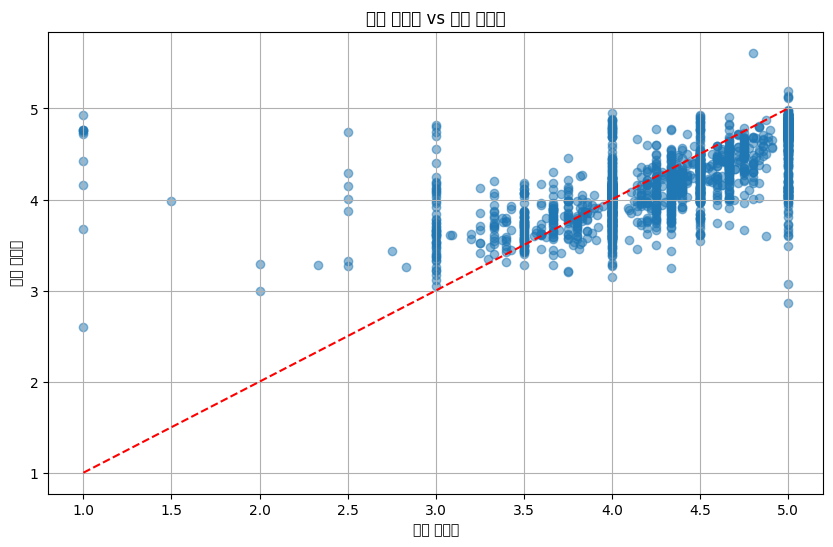

테스트 데이터 RMSE: 0.4591


In [139]:
# 모델 성능 평가를 위한 실제값과 예측값 비교
y_pred = model.predict(test_inputs)

# 예측값과 실제값 비교 시각화
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('실제 만족도')
plt.ylabel('예측 만족도')
plt.title('실제 만족도 vs 예측 만족도')
plt.grid(True)
plt.show()

# RMSE 계산
from sklearn.metrics import mean_squared_error
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"테스트 데이터 RMSE: {rmse:.4f}")

## 10. 결론 및 향후 개선점

### 기능 추가
감